# Código Arbol de decisión para clasificación
POr Liceth Mosquera

## Librerias necesarias

In [28]:
# Imports needed for the script
import numpy as np
import pandas as pd
import itertools as it
import seaborn as sns
# from sklearn.tree import DecisionTreeClassifier as DTC

from Orange.classification import tree

from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

## Explorando los datos

In [29]:
Data = pd.read_excel('Data.xlsx')
Data = Data.set_index('Date')
df1 = Data.dropna(axis=0,how='any')
Y = df1['Class']
X = df1.drop('Class', axis = 1)
df1.groupby('Class').size()

Class
-1    1111
 0    2001
 1     963
dtype: int64

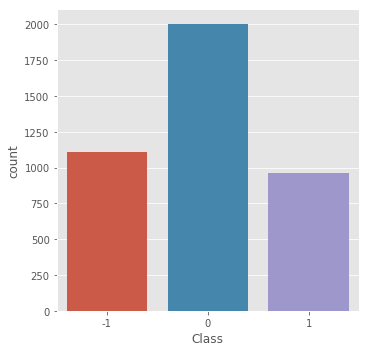

In [30]:
sns.catplot('Class',data=df1,kind="count")

In [31]:
#Por el momento no se utiliza ninguna de estas variables
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()

##  1. Error real deseado $\epsilon$  y 2. Error de entrenamiento deseado $\delta$ .Parametros

In [32]:
Hpyer_Parameters = [[i for i in range(1,6)], # max_depth sin embargo dada la cantidad de datos la profundidad maxima es de 5
                    [i for i in range(1,20)]] # min_samples_leaf

set_parameters = [i for i in it.product(*Hpyer_Parameters)]

Epsilon = 0.2 #error real
delta = 0.1  #error de entrenamiento
step=10
h_aprox = len(set_parameters) #hipotesis para una regresión lineal

## 3. Garantia probable de aprendizaje

In [33]:
n_est = int(np.ceil((1/Epsilon)*(np.log(len(set_parameters)) + np.log(1/delta))))
n_est

35

## 4. Tamaño óptimo de la muestra

In [34]:
muestra=np.zeros(8)
num=list(range(8))
max_attributes=len(list(df1)) #esta si se usa
depth_range = range(1, max_attributes + 1)
k=3

In [35]:
def m_opt_tree(k,delta,Epsilon,max_attributes):
            return int((np.log(2)/(2*Epsilon**2))*(((2**k)-1)*(1+np.log2(max_attributes-1))+1+np.log(1/delta)))

In [36]:
muestra=(m_opt_tree(k,delta,Epsilon,max_attributes))
muestra  #muestra minima para entrenar un arbol de las diferentes profundidades

457

In [37]:
n_opt=list(range(8))
for k in range(0,8): #profundidad del arbol
    n_opt[k]=(m_opt_tree(k,delta,Epsilon,max_attributes))
min_n=pd.DataFrame(n_opt,num)
min_n

,0
0,28
1,89
2,212
3,457
4,946
5,1926
6,3885
7,7803


Dado que mi cantidad de datos es 4075 solo puedo entregar arboles de maxima profundidad de 5. el 60% de los datos que necesito para entrenar el modelo maximo podría tomar 2455 datos, por lo que una profundidad de 6 ya no aplica.

### 5. Dividir el conjunto de muestra en: entrenamiento, validación y prueba.

In [38]:
# Se van a utilizar todos los datos para encontrar el mejor arbol
X1_tr, X1_ts, Y1_tr, Y1_ts = train_test_split(X, Y, test_size=0.4, train_size = 0.6,random_state=19)
X1_va, X1_va2, Y1_va, Y1_va2 = train_test_split(X1_ts, Y1_ts, test_size=0.5,train_size = 0.5, random_state=19)

### 8.	Entrenar el modelo con los datos en altas dimensiones (espacio original)

In [39]:
best_accur=np.zeros(len(set_parameters))

for i in range(len(set_parameters)):
    dtc = DecisionTreeClassifier(max_depth = set_parameters[i][0], min_samples_leaf= set_parameters[i][1], random_state=19)
    dtc.fit(X1_tr, Y1_tr)
    y_pred = dtc.predict(X1_ts)
    best_accur[i]=accuracy_score(Y1_ts, y_pred)
ind_bst = np.where(best_accur == np.amax(best_accur))[0][0]
ind_bst 
set_parameters[ind_bst]

(2, 1)

In [40]:
print ('El mejor modelo tiene una profundidad de', set_parameters[ind_bst][0])
print ('y un cantidad de hojas ', set_parameters[ind_bst][1])

El mejor modelo tiene una profundidad de 2
y un cantidad de hojas  1


In [41]:
accur=np.zeros(int((len(X)*0.6)/step))
Conf_Mat= np.zeros((int((len(X)*0.6)/step),3,3))
R_rta=pd.DataFrame(accur,Conf_Mat)
R_rta.all()
accur
num=list(range(len(accur)))
#Conf_Mat

In [42]:
n=int(n_opt[set_parameters[ind_bst][0]])
n

212

In [43]:
N=range(n,round(len(X)*0.6),step) 
N

range(212, 2445, 10)

In [44]:
best_dtc = DecisionTreeClassifier(max_depth = set_parameters[ind_bst][0],min_samples_leaf= set_parameters[ind_bst][1]
                                  , random_state=19)
for i in range(len(N)):
    Xb_tr, Xb_o, Yb_tr, Yb_o = train_test_split(X1_tr, Y1_tr,test_size=0.01,train_size=N[i]/X.shape[0],random_state=19)  
                                            
    best_dtc.fit(Xb_tr, Yb_tr)
    y_pred = best_dtc.predict(X1_ts)
    accur[i] = accuracy_score(Y1_ts,y_pred)
    Conf_Mat[i,:,:] = confusion_matrix(Y1_ts,y_pred)

La cantidad de datos son 4075, como se debe ir aumentando la muestra para el entrenamiento del modelo maximo esta puede llegar maximo a 2,852, que representa alrededor del 70% de los datos, de ahi en adelante no hay forma de seguir entrenando. 
El mejor accuracy está es para un tamaño de muestra de 2,227, llegando a 0.536 de ahi el modelo empieza a desmejorar.

In [45]:
max(accur)

0.5263803680981595

In [46]:
n_bst = np.where(accur == np.amax(accur))[0]
n_bst

array([124, 126, 127, 128, 129, 134, 135, 136, 137, 144, 145, 152, 154,
       155, 165, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181],
      dtype=int64)

Para el modelo escogido el mejor acuracy se da con solo 222 datos.

In [47]:
accur[n_bst]

array([0.52638037, 0.52638037, 0.52638037, 0.52638037, 0.52638037,
       0.52638037, 0.52638037, 0.52638037, 0.52638037, 0.52638037,
       0.52638037, 0.52638037, 0.52638037, 0.52638037, 0.52638037,
       0.52638037, 0.52638037, 0.52638037, 0.52638037, 0.52638037,
       0.52638037, 0.52638037, 0.52638037, 0.52638037, 0.52638037,
       0.52638037])

In [48]:
a = []
for i in range(0,244): #len(N)-1
    i=n+i*step
    a.append(i)
#print(a)

Text(0.5, 0, 'Cantidad datos')

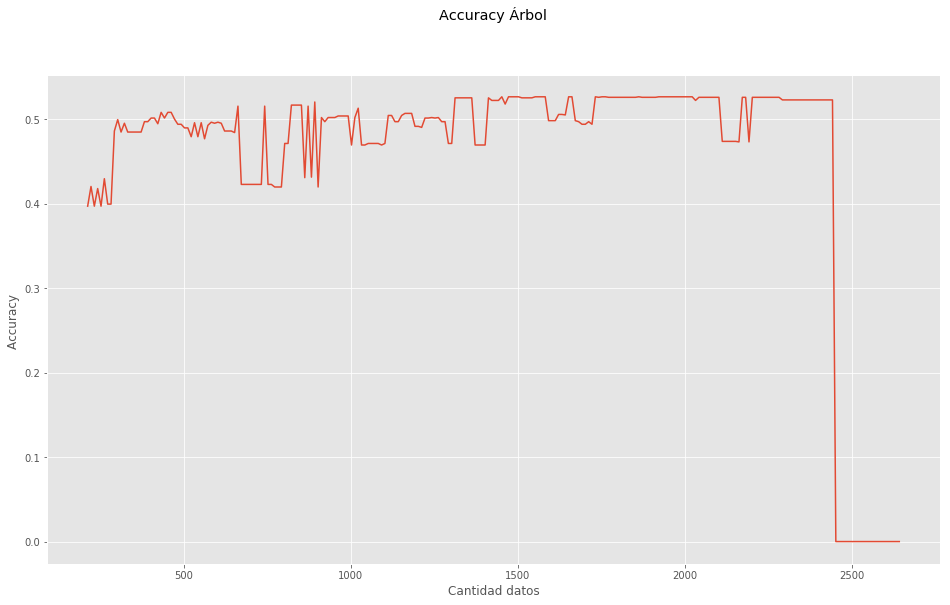

In [49]:
plt.plot(a,accur)
plt.title('Accuracy Árbol', y=1.1)
plt.ylabel('Accuracy ')
plt.xlabel('Cantidad datos')

In [50]:
# precisión del modelo en datos de entrenamiento.
print("precisión entranamiento: {0: .2f}".format(best_dtc.score(Xb_tr, Yb_tr)))

precisión entranamiento:  0.54


In [51]:
# precisión del modelo en datos de evaluación.
print("precisión evaluación: {0: .2f}".format(best_dtc.score( X1_ts, Y1_ts)))

precisión evaluación:  0.52


In [52]:
# precisión del modelo en datos de evaluación.
print("precisión evaluación: {0: .2f}".format(best_dtc.score( Xb_o, Yb_o)))

precisión evaluación:  0.44


Text(0.5, 574.24, 'Predicted label')

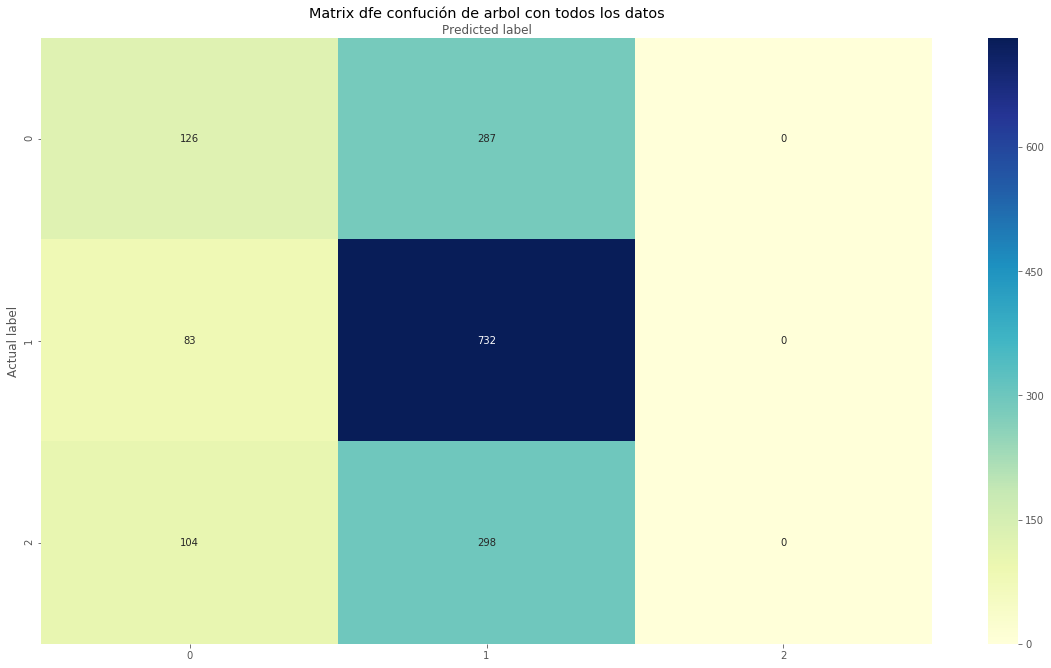

In [53]:
class_names=[-1,0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(Conf_Mat[n_bst[0]]), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrix dfe confución de arbol con todos los datos', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
np.sum(Conf_Mat[n_bst[0]].diagonal())

858.0

In [55]:
#Modelo con mejor accuracy. 

Xb_tr2, Xb_o, Yb_tr2, Yb_o = train_test_split(X1_tr, Y1_tr,test_size=0.01,train_size=n_bst[0]/X.shape[0],random_state=19)
best_dtc2 = DecisionTreeClassifier(max_depth = set_parameters[ind_bst][0],min_samples_leaf= set_parameters[ind_bst][1]
                                  , random_state=123)
                                        
best_dtc2.fit(Xb_tr2, Yb_tr2)
y_pred_best = best_dtc2.predict(X1_ts)
accur_best = accuracy_score(Y1_ts,y_pred_best)
Conf_Mat2_best = confusion_matrix(Y1_ts,y_pred_best)

Text(0.5, 574.24, 'Predicted label')

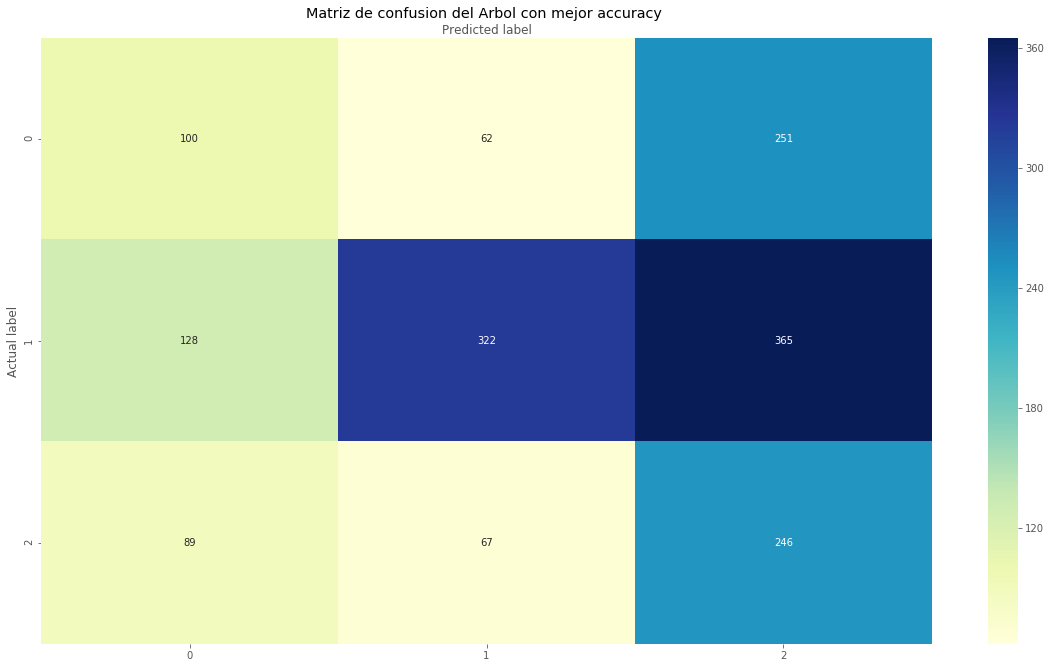

In [56]:
class_names=[-1,0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(Conf_Mat2_best), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusion del Arbol con mejor accuracy ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [57]:
np.sum(Conf_Mat2_best.diagonal())

668

# Problema binario

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [59]:
# Binarize the output
y = label_binarize(Y, classes=[-1, 0, 1])
n_classes = y.shape[1]
n_classes

3

In [60]:
Xb_tr, X2_o, Yb_tr, y2_o = train_test_split(X, y,test_size=0.3,random_state=19)  

Xb_va2, Xb_test2, Yb_va2, Yb_test2 = train_test_split(X2_o, y2_o, test_size=0.5, train_size = 0.5, random_state=19)  

#parte los datos con respecto a la y binarizada

In [61]:
int((len(X)*0.6)/step)

244

In [62]:
Y_Score={
    'Model': [None for i in range(int((len(X)*0.6)/step))],
    'Acc_Test': np.zeros((int((len(X)*0.6)/step),3,3)),
    'Acc_Val': np.zeros((int((len(X)*0.6)/step),3,3))
}
#Y_Score=dict()
Y_Score;

In [63]:
Tree =OneVsRestClassifier(DecisionTreeClassifier(max_depth = set_parameters[ind_bst][0],min_samples_leaf= set_parameters[ind_bst][1]
                              , random_state=19))
for i in range(len(N)):
    Xb_tr, X3_o, Yb_tr, y3_o  = train_test_split(X, y,test_size=((N[i]/X.shape[0])*0.4/0.6)
                                                ,train_size=N[i]/X.shape[0],random_state=19)  
                                    
    Y_Score=Tree.fit(Xb_tr, Yb_tr).predict_proba(X2_o)
    # Y_Score[i,:,:]=y_score
    Y_pred = Tree.predict(X2_o)
    Y_proba = Tree.predict_proba(X2_o)

In [64]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y2_o[:, i], Y_Score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])

In [65]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y2_o.ravel(), Y_Score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

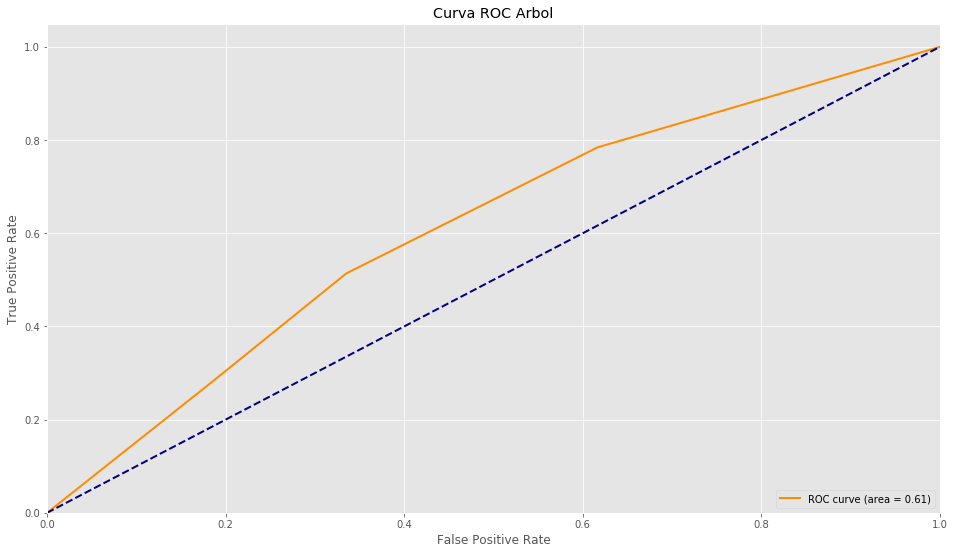

In [66]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Arbol')
plt.legend(loc="lower right")
plt.show()

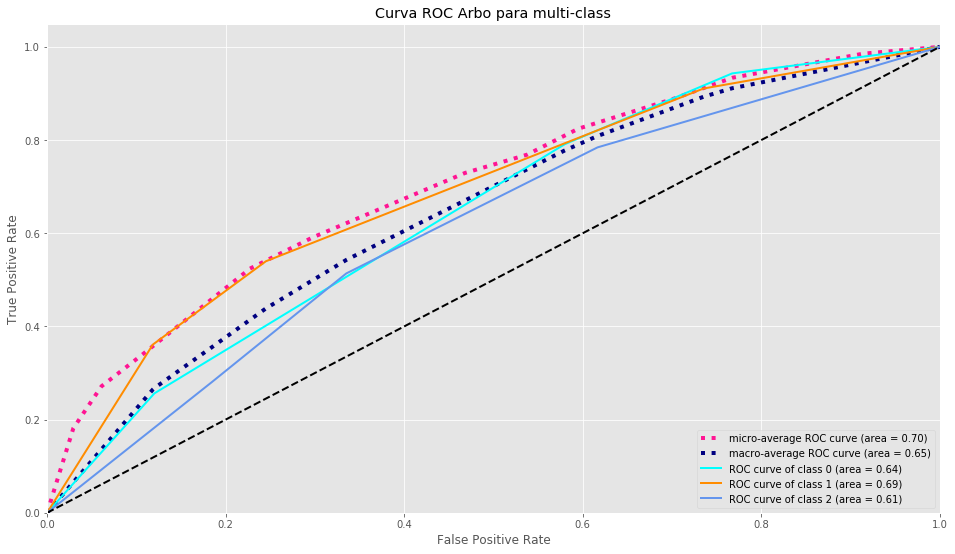

In [67]:
from scipy import interp
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Arbo para multi-class')
plt.legend(loc="lower right")
plt.show()